In [1]:
import numpy as np
import pandas as pd

batting = pd.read_csv('./Data/Batting.csv')

In [2]:
batting = batting[ (batting['yearID'] >=1987) & (batting['yearID'] <=2012)]
batting = batting [ (batting['AB'] > 100) & (batting['G'] > 81)]
batting = batting.drop(['stint', 'teamID', 'lgID', 'G_batting', 'G_old'], axis = 1)

In [3]:
allstars = pd.read_csv('./Data/AllstarFull.csv')
allstars = allstars[ (allstars['yearID'] >=1987) & (allstars['yearID'] <=2012)]
allstars = allstars[['playerID', 'yearID', 'gameID']]

In [4]:
merged = pd.merge(batting, allstars, how = 'left', on = ['playerID', 'yearID'])

In [5]:
merged['All-Star'] = np.where(merged['gameID'].notnull() , True, False)

In [6]:
merged['1B'] = merged['H'] - (merged['2B'] + merged['3B'] + merged['HR'])
merged['SLG'] = (merged['1B'] + (2*merged['2B']) + (3*merged['3B']) + (4*merged['HR'])) / merged['AB']
merged['AVG'] = merged['H'] / merged['AB']
merged['OBP'] = (merged['H'] + merged['BB'] + merged['HBP']) / (merged['AB'] + merged['BB'] + merged['HBP'] + merged['SF'])
merged['ISO'] = merged['SLG'] - merged['AVG']
merged['OPS'] = merged['OBP'] + merged['SLG']
merged = merged.drop(['playerID', 'yearID', 'gameID', 'G', 'SF', 'SH', 'HBP', 'GIDP', 'CS', 'IBB'], axis=1)
merged

,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,All-Star,1B,SLG,AVG,OBP,ISO,OPS
0,244.0,33.0,68.0,14.0,1.0,12.0,41.0,3.0,9.0,28.0,False,41.0,0.491803,0.278689,0.298450,0.213115,0.790253
1,345.0,41.0,86.0,17.0,3.0,9.0,33.0,3.0,16.0,98.0,False,57.0,0.394203,0.249275,0.290761,0.144928,0.684964
2,420.0,60.0,107.0,18.0,7.0,17.0,60.0,4.0,36.0,110.0,False,65.0,0.452381,0.254762,0.317597,0.197619,0.769978
3,320.0,37.0,81.0,18.0,7.0,8.0,33.0,3.0,22.0,99.0,False,48.0,0.428125,0.253125,0.307246,0.175000,0.735371
4,252.0,35.0,69.0,18.0,2.0,6.0,30.0,3.0,14.0,68.0,False,43.0,0.432540,0.273810,0.314607,0.158730,0.747146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7493,541.0,77.0,129.0,28.0,2.0,10.0,75.0,24.0,92.0,107.0,False,89.0,0.353050,0.238447,0.345679,0.114603,0.698729
7494,588.0,99.0,158.0,46.0,6.0,20.0,91.0,19.0,77.0,128.0,False,86.0,0.469388,0.268707,0.352679,0.200680,0.822066
7495,560.0,88.0,151.0,39.0,7.0,20.0,74.0,14.0,97.0,103.0,False,85.0,0.471429,0.269643,0.376877,0.201786,0.848305
7496,392.0,46.0,108.0,19.0,1.0,3.0,43.0,2.0,25.0,60.0,False,85.0,0.352041,0.275510,0.322353,0.076531,0.674394


In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
%matplotlib inline


In [8]:
merged_x = merged.drop('All-Star', 1)
merged_y = merged['All-Star']

In [9]:
from sklearn.model_selection import train_test_split

merged_x_train, merged_x_test, merged_y_train, merged_y_test = train_test_split(merged_x, merged_y, random_state = 42, train_size = 0.7)

In [10]:
print(len(merged_x), len(merged_x_test), len(merged_x_train))

7498 2250 5248


In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l1', 'l2'],
         'C': [0.01, 0.1, 1, 10]}

log_regression_model = LogisticRegression(class_weight='balanced', max_iter = 700)

grid_search_log_reg = GridSearchCV(log_regression_model, 
                                    param_grid=params,  
                                   cv=10, 
                                   n_jobs = 2  
                                   )
grid_search_log_reg.fit(merged_x_train, merged_y_train)

best_log_reg = grid_search_log_reg.best_estimator_

print(grid_search_log_reg.best_params_)

{'C': 10, 'penalty': 'l2'}


In [13]:
import sklearn.metrics as sklmetrics

merged_pred_Y = best_log_reg.predict(merged_x_test)

print('The accuracy score is {}'.format(sklmetrics.accuracy_score(merged_y_test, merged_pred_Y)))


The accuracy score is 0.7875555555555556


[[1526  412]
 [  66  246]]


Text(91.68, 0.5, 'True Value')

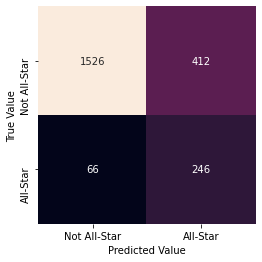

In [14]:
conf_mat = sklmetrics.confusion_matrix(merged_y_test, merged_pred_Y)
print(conf_mat)

sns.heatmap(conf_mat, fmt='d',square=True, annot=True, cbar = False, xticklabels = ['Not All-Star','All-Star'], 
                                                            yticklabels = ['Not All-Star','All-Star'])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

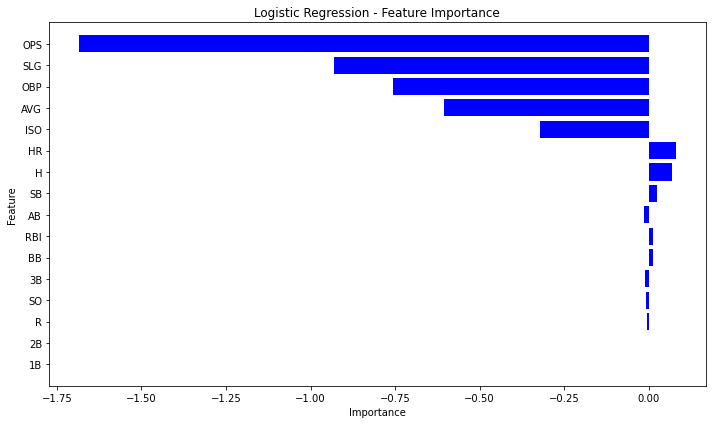

In [15]:
def plot_feature_importance_coeff(model, Xnames, cls_nm = None):

    imp_features = pd.DataFrame(np.column_stack((Xnames, model.coef_.ravel())), columns = ['feature', 'importance'])
    imp_features[['importance']] = imp_features[['importance']].astype(float)
    imp_features[['abs_importance']] = imp_features[['importance']].abs()
    imp_features = imp_features.sort_values(by = ['abs_importance'], ascending = [1])
    plt.figure(figsize=(10,6))
    plt.title(cls_nm + " - Feature Importance")
    plt.barh(range(imp_features.shape[0]), imp_features['importance'],
            color="b", align="center")
    plt.yticks(range(imp_features.shape[0]), imp_features['feature'], )
    plt.ylim([-1, imp_features.shape[0]])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout() 
    plt.savefig(cls_nm + "_feature_imp.png", bbox_inches='tight')
    plt.show()
    
plot_feature_importance_coeff(best_log_reg, merged_x_train.columns, cls_nm="Logistic Regression")

In [16]:
from sklearn.tree import DecisionTreeClassifier

dec_tree_model = DecisionTreeClassifier(class_weight='balanced')

dec_tree_model.fit(merged_x_train, merged_y_train)

DecisionTreeClassifier(class_weight='balanced')

In [17]:
params = {'max_depth':[3,4,5],
          'max_features':['auto','log2',None]}

grid_search_dec_tree = GridSearchCV(dec_tree_model, 
                                    param_grid=params,  
                                   cv=3, 
                                   n_jobs = 1 
                                   )

grid_search_dec_tree.fit(merged_x_train, merged_y_train)

best_dec_tree_cv = grid_search_dec_tree.best_estimator_

print(grid_search_dec_tree.best_params_)

{'max_depth': 5, 'max_features': 'log2'}


In [18]:
merged_y_pred = best_dec_tree_cv.predict(merged_x_test)

print('The accuracy score is {}'.format(sklmetrics.accuracy_score(merged_y_test, merged_y_pred)))


The accuracy score is 0.7666666666666667


[[1493  445]
 [  80  232]]


Text(91.68, 0.5, 'True Value')

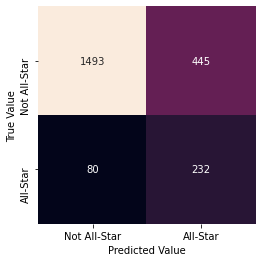

In [19]:
conf_mat = sklmetrics.confusion_matrix(merged_y_test, merged_y_pred)
print(conf_mat)

sns.heatmap(conf_mat, fmt='d',square=True, annot=True, cbar = False, xticklabels = ['Not All-Star','All-Star'], 
                                                            yticklabels = ['Not All-Star','All-Star'])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

In [20]:
def plot_feature_importance(model, Xnames, cls_nm = None):

    imp_features = pd.DataFrame(np.column_stack((Xnames, model.feature_importances_)), columns = ['feature', 'importance'])
    imp_features[['importance']] = imp_features[['importance']].astype(float)
    imp_features[['abs_importance']] = imp_features[['importance']].abs()
    imp_features = imp_features.sort_values(by = ['abs_importance'], ascending = [1])
    imp_features = imp_features.iloc[10:]
    plt.figure(figsize=(10,6))
    plt.title(cls_nm + " - Feature Importance")
    plt.barh(range(imp_features.shape[0]), imp_features['importance'],
            color="b", align="center")
    plt.yticks(range(imp_features.shape[0]), imp_features['feature'], )
    plt.ylim([-1, imp_features.shape[0]])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout() 
    plt.savefig(cls_nm + "_feature_imp.png", bbox_inches='tight')
    plt.show()

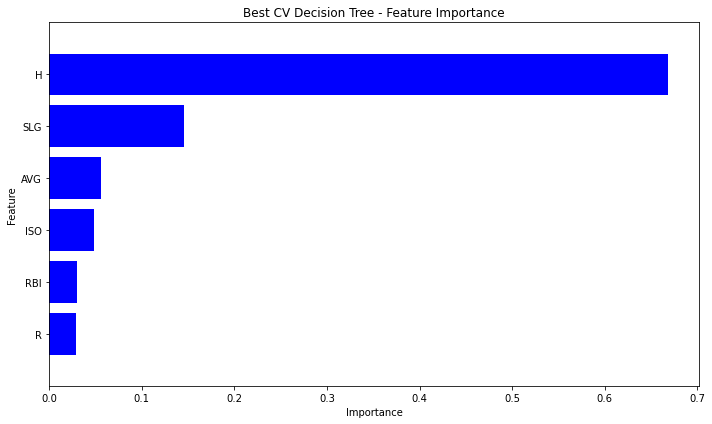

In [21]:
plot_feature_importance(best_dec_tree_cv, merged_x.columns, cls_nm='Best CV Decision Tree')

Let's see the impact of fielding statistics!

In [22]:
fielding = pd.read_csv('./Data/fielding.csv')

In [23]:
fielding = fielding[ (fielding['yearID'] >= 1987) & (fielding['yearID'] <= 2012)]
fielding = fielding[ fielding['G'] > 81]
fielding = fielding[ (fielding['POS'] != 'P') & (fielding['POS'] != 'C') & (fielding['POS'] != '1B')]
fielding['Fld%'] = (fielding['PO'] + fielding['A']) / (fielding['E'] + fielding['PO'] + fielding['A'])

In [24]:
fielding = fielding[['playerID', 'yearID', 'PO', 'A', 'E', 'DP', 'Fld%']]
fielding.fillna(0, inplace = True)

In [25]:
fielding.head()

,playerID,yearID,PO,A,E,DP,Fld%
210,abbotku01,1994,162.0,260.0,15.0,61.0,0.965675
211,abbotku01,1995,149.0,290.0,19.0,66.0,0.958515
273,abercre01,2006,172.0,3.0,5.0,0.0,0.972222
275,abercre01,2006,176.0,3.0,5.0,1.0,0.972826
286,abernbr01,2002,253.0,316.0,12.0,85.0,0.979346


In [26]:
batting['1B'] = (batting['H'] - (batting['2B'] + batting['3B'] + batting['HR']))
batting['SLG'] = (batting['1B'] + (2*batting['2B']) + (3*batting['3B']) + (4*batting['HR'])) / batting['AB']
batting['AVG'] = batting['H'] / batting['AB']
batting['OBP'] = (batting['H'] + batting['BB'] + batting['HBP']) / (batting['AB'] + batting['BB'] + batting['HBP'] + batting['SF'])
batting['ISO'] = batting['SLG'] - batting['AVG']
batting['OPS'] = batting['OBP'] + batting['SLG']
batting = batting.drop(['G', 'SF', 'SH', 'HBP', 'GIDP', 'CS', 'IBB'], axis=1)
batting.head()

,playerID,yearID,AB,R,H,2B,3B,HR,RBI,SB,BB,SO,1B,SLG,AVG,OBP,ISO,OPS
96,abbotje01,1998,244.0,33.0,68.0,14.0,1.0,12.0,41.0,3.0,9.0,28.0,41.0,0.491803,0.278689,0.298450,0.213115,0.790253
112,abbotku01,1994,345.0,41.0,86.0,17.0,3.0,9.0,33.0,3.0,16.0,98.0,57.0,0.394203,0.249275,0.290761,0.144928,0.684964
113,abbotku01,1995,420.0,60.0,107.0,18.0,7.0,17.0,60.0,4.0,36.0,110.0,65.0,0.452381,0.254762,0.317597,0.197619,0.769978
114,abbotku01,1996,320.0,37.0,81.0,18.0,7.0,8.0,33.0,3.0,22.0,99.0,48.0,0.428125,0.253125,0.307246,0.175000,0.735371
115,abbotku01,1997,252.0,35.0,69.0,18.0,2.0,6.0,30.0,3.0,14.0,68.0,43.0,0.432540,0.273810,0.314607,0.158730,0.747146


In [27]:
batting_fielding = pd.merge(fielding, batting, how = 'inner', on = ['playerID', 'yearID'])

In [28]:
batting_fielding_merge = pd.merge(batting_fielding, allstars, how = 'left', on = ['playerID', 'yearID'])

In [29]:
batting_fielding_merge['All-Star'] = np.where(batting_fielding_merge['gameID'].notnull(), True, False) 

In [30]:
batting_fielding_merge

,playerID,yearID,PO,A,E,DP,Fld%,AB,R,H,...,BB,SO,1B,SLG,AVG,OBP,ISO,OPS,gameID,All-Star
0,abbotku01,1994,162.0,260.0,15.0,61.0,0.965675,345.0,41.0,86.0,...,16.0,98.0,57.0,0.394203,0.249275,0.290761,0.144928,0.684964,NaN,False
1,abbotku01,1995,149.0,290.0,19.0,66.0,0.958515,420.0,60.0,107.0,...,36.0,110.0,65.0,0.452381,0.254762,0.317597,0.197619,0.769978,NaN,False
2,abercre01,2006,172.0,3.0,5.0,0.0,0.972222,255.0,39.0,54.0,...,18.0,78.0,35.0,0.333333,0.211765,0.270758,0.121569,0.604091,NaN,False
3,abercre01,2006,176.0,3.0,5.0,1.0,0.972826,255.0,39.0,54.0,...,18.0,78.0,35.0,0.333333,0.211765,0.270758,0.121569,0.604091,NaN,False
4,abernbr01,2002,253.0,316.0,12.0,85.0,0.979346,463.0,46.0,112.0,...,25.0,46.0,88.0,0.311015,0.241901,0.288306,0.069114,0.599322,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947,zobribe01,2010,204.0,6.0,0.0,3.0,1.000000,541.0,77.0,129.0,...,92.0,107.0,89.0,0.353050,0.238447,0.345679,0.114603,0.698729,NaN,False
5948,zobribe01,2010,182.0,6.0,0.0,3.0,1.000000,541.0,77.0,129.0,...,92.0,107.0,89.0,0.353050,0.238447,0.345679,0.114603,0.698729,NaN,False
5949,zobribe01,2011,213.0,316.0,6.0,68.0,0.988785,588.0,99.0,158.0,...,77.0,128.0,86.0,0.469388,0.268707,0.352679,0.200680,0.822066,NaN,False
5950,zupcibo01,1992,241.0,11.0,6.0,3.0,0.976744,392.0,46.0,108.0,...,25.0,60.0,85.0,0.352041,0.275510,0.322353,0.076531,0.674394,NaN,False


In [31]:
batting_fielding_merge.drop(['gameID', 'playerID', 'yearID', '1B'], axis = 1, inplace = True)

In [32]:
batting_fielding_merge_x = batting_fielding_merge.drop('All-Star', 1)
batting_fielding_merge_y = batting_fielding_merge['All-Star']

In [33]:
batting_fielding_merge_x_train, batting_fielding_merge_x_test, batting_fielding_merge_y_train, batting_fielding_merge_y_test = train_test_split(batting_fielding_merge_x, batting_fielding_merge_y, random_state = 42, train_size = 0.7)

In [34]:
print(len(batting_fielding_merge_x), len(batting_fielding_merge_x_train), len(batting_fielding_merge_x_test))

5952 4166 1786


In [35]:
dec_tree = DecisionTreeClassifier(class_weight='balanced')

dec_tree.fit(batting_fielding_merge_x_train, batting_fielding_merge_y_train)

DecisionTreeClassifier(class_weight='balanced')

In [36]:
params = {'max_depth':[3,4,5],
          'max_features':['auto','log2', None]}


search_dec_tree = GridSearchCV(dec_tree, 
                                    param_grid=params, 
                                   cv=3, 
                                   n_jobs = 1 
                                   )

search_dec_tree.fit(batting_fielding_merge_x_train, batting_fielding_merge_y_train)

best_decision_tree = search_dec_tree.best_estimator_

print(search_dec_tree.best_params_)

{'max_depth': 5, 'max_features': None}


In [37]:
batting_fielding_merge_y_pred = best_decision_tree.predict(batting_fielding_merge_x_test)


print('The accuracy score is {}'.format(sklmetrics.accuracy_score(batting_fielding_merge_y_test, batting_fielding_merge_y_pred)))

The accuracy score is 0.7631578947368421


[[1092  366]
 [  57  271]]


Text(91.68, 0.5, 'True Value')

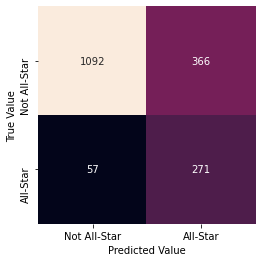

In [38]:
conf_mat = sklmetrics.confusion_matrix(batting_fielding_merge_y_test, batting_fielding_merge_y_pred)
print(conf_mat)


sns.heatmap(conf_mat, fmt='d',square=True, annot=True, cbar = False, xticklabels = ['Not All-Star','All-Star'], 
                                                            yticklabels = ['Not All-Star','All-Star'])
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

In [39]:
importances = best_decision_tree.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(batting_fielding_merge_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 19 (0.508542)
2. feature 7 (0.145715)
3. feature 6 (0.111352)
4. feature 15 (0.045627)
5. feature 14 (0.035207)
6. feature 1 (0.034465)
7. feature 5 (0.028563)
8. feature 11 (0.020538)
9. feature 3 (0.020438)
10. feature 16 (0.012745)
11. feature 2 (0.010682)
12. feature 9 (0.006988)
13. feature 0 (0.006585)
14. feature 10 (0.006506)
15. feature 8 (0.006047)
16. feature 18 (0.000000)
17. feature 4 (0.000000)
18. feature 12 (0.000000)
19. feature 13 (0.000000)
20. feature 17 (0.000000)


In [40]:
for col in batting_fielding_merge.columns: 
    print(col) 

PO
A
E
DP
Fld%
AB
R
H
2B
3B
HR
RBI
SB
BB
SO
SLG
AVG
OBP
ISO
OPS
All-Star


In [52]:
batters_2020_ = pd.read_csv('./Data/2020_batting.csv', encoding = 'latin-1')
batters_2020_.head()

,Rk,Name,Age,Tm,Lg,G,PA,AB,R,H,...,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,Pos Summary
0,1,José Abreu,33,CHW,AL,60,262,240,43,76,...,0.617,0.987,166.0,148,10,3,0,1,1,3/D
1,2,Ronald Acuna Jr.,22,ATL,NL,46,202,160,46,40,...,0.581,0.987,155.0,93,3,4,0,0,2,89
2,3,Willy Adames,24,TBR,AL,54,205,185,29,48,...,0.481,0.813,124.0,89,4,0,0,0,0,6/H
3,4,Austin Adams,29,SDP,NL,1,1,1,0,0,...,0.000,0.000,-100.0,0,0,0,0,0,0,/1
4,5,Matt Adams,31,ATL,NL,16,51,49,4,9,...,0.347,0.563,44.0,17,3,0,0,0,0,D/H3


In [53]:
batters_2020_ = batters_2020_ [ (batters_2020_['G'] > 25) & (batters_2020_['AB'] > 100)]
batters_2020_ = batters_2020_[['Name', 'Lg', 'AB', 'H', '2B', '3B', 'RBI', 'OPS', 'SLG', 'OBP', 'SO', 'BA', 'HR', 'SB', 'BB', 'R']]
batters_2020_

,Name,Lg,AB,H,2B,3B,RBI,OPS,SLG,OBP,SO,BA,HR,SB,BB,R
0,José Abreu,AL,240,76,15,0,60,0.987,0.617,0.370,59,0.317,19,0,18,43
1,Ronald Acuna Jr.,NL,160,40,11,0,29,0.987,0.581,0.406,60,0.250,14,8,38,46
2,Willy Adames,AL,185,48,15,1,23,0.813,0.481,0.332,74,0.259,8,2,20,29
5,Jo Adell,AL,124,20,4,0,7,0.478,0.266,0.212,55,0.161,3,0,7,9
7,Jesus Aguilar,NL,188,52,10,0,34,0.809,0.457,0.352,40,0.277,8,0,23,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,Evan White,AL,182,32,7,0,26,0.599,0.346,0.252,84,0.176,8,1,18,19
685,Jesse Winker,NL,149,38,7,0,23,0.932,0.544,0.388,46,0.255,12,1,28,27
689,Kolten Wong,NL,181,48,4,2,16,0.675,0.326,0.350,30,0.265,1,5,20,26
691,Mike Yastrzemski,NL,192,57,14,4,35,0.968,0.568,0.400,55,0.297,10,2,30,39


In [54]:
fielders_2020 = pd.read_csv('./Data/2020_fielding.csv', encoding = 'latin-1')

In [55]:
fielders_2020.head()

,Rk,Name,Age,Tm,Lg,G,GS,CG,Inn,Ch,...,DP,Fld%,Rtot,Rtot/yr,Rdrs,Rdrs/yr,Rgood,RF/9,RF/G,Pos Summary
0,1,Albert Abreu,24,NYY,AL,2,0,0,1.1,0,...,0,NaN,NaN,NaN,0.0,0.0,NaN,0.00,0.00,P
1,2,Bryan Abreu,23,HOU,AL,4,0,0,3.1,2,...,0,1.000,NaN,NaN,0.0,0.0,0.0,5.40,0.50,P
2,3,José Abreu,33,CHW,AL,54,54,53,470.0,462,...,39,0.989,3.0,7.0,5.0,13.0,-1.0,8.75,8.46,1B
3,4,Ronald Acuna Jr.,22,ATL,NL,46,46,26,376.2,102,...,0,1.000,9.0,30.0,NaN,NaN,NaN,2.44,2.22,OF
4,5,Jason Adam,28,CHC,NL,13,0,0,13.2,3,...,0,0.667,NaN,NaN,0.0,0.0,0.0,1.32,0.15,P


In [56]:
fielders_2020 = fielders_2020[['Name', 'PO', 'A', 'E', 'DP', 'Fld%']]
fielders_2020 = fielders_2020.iloc[:1280]
fielders_2020

,Name,PO,A,E,DP,Fld%
0,Albert Abreu,0,0,0,0,NaN
1,Bryan Abreu,2,0,0,0,1.000
2,José Abreu,430,27,5,39,0.989
3,Ronald Acuna Jr.,102,0,0,0,1.000
4,Jason Adam,0,2,1,0,0.667
...,...,...,...,...,...,...
1274,Kyle Zimmer,2,4,0,1,1.000
1275,Bruce Zimmermann,0,0,0,0,NaN
1276,Jordan Zimmermann,0,1,0,0,1.000
1277,Tyler Zuber,0,2,0,0,1.000


In [57]:
bat_field = pd.merge(batters_2020_, fielders_2020, how = 'inner', on = 'Name')

In [58]:
bat_field

,Name,Lg,AB,H,2B,3B,RBI,OPS,SLG,OBP,...,BA,HR,SB,BB,R,PO,A,E,DP,Fld%
0,José Abreu,AL,240,76,15,0,60,0.987,0.617,0.370,...,0.317,19,0,18,43,430,27,5,39,0.989
1,Ronald Acuna Jr.,NL,160,40,11,0,29,0.987,0.581,0.406,...,0.250,14,8,38,46,102,0,0,0,1.000
2,Willy Adames,AL,185,48,15,1,23,0.813,0.481,0.332,...,0.259,8,2,20,29,53,131,9,27,0.953
3,Jo Adell,AL,124,20,4,0,7,0.478,0.266,0.212,...,0.161,3,0,7,9,72,2,3,0,0.961
4,Jesus Aguilar,NL,188,52,10,0,34,0.809,0.457,0.352,...,0.277,8,0,23,31,243,20,3,36,0.989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Evan White,AL,182,32,7,0,26,0.599,0.346,0.252,...,0.176,8,1,18,19,370,32,1,36,0.998
280,Jesse Winker,NL,149,38,7,0,23,0.932,0.544,0.388,...,0.255,12,1,28,27,20,0,0,0,1.000
281,Kolten Wong,NL,181,48,4,2,16,0.675,0.326,0.350,...,0.265,1,5,20,26,59,129,2,29,0.989
282,Mike Yastrzemski,NL,192,57,14,4,35,0.968,0.568,0.400,...,0.297,10,2,30,39,120,2,0,1,1.000


Most Important Features (Hitting and Fielding)

1. feature 19 (0.508542) OPS
2. feature 7 (0.145715)  H
3. feature 6 (0.111352)  R
4. feature 15 (0.045627) SLG
5. feature 14 (0.035207) SO
6. feature 1 (0.034465)  A
7. feature 5 (0.028563)  AB
8. feature 11 (0.020538) RBI
9. feature 3 (0.020438)  DP
10. feature 16 (0.012745)BA
11. feature 2 (0.010682) E
12. feature 9 (0.006988) 3B
13. feature 0 (0.006585) PO
14. feature 10 (0.006506) HR
15. feature 8 (0.006047) 2B

In [60]:
bat_field['All-Star Index'] = (0.508542*bat_field['OPS']) + (0.145715*bat_field['H'] + (0.111352*bat_field['R']) + (0.045627*bat_field['SLG']) - (0.035207*bat_field['SO']) + (0.034465*bat_field['A']) + (0.021939*bat_field['AB']) + (0.020538*bat_field['RBI']) + (0.020438*bat_field['DP']) + (0.012745*bat_field['BA']) - (0.010682*bat_field['E']) + (0.006988*bat_field['3B']) + (0.006585*bat_field['PO']) + (0.006506*bat_field['HR']) + (0.006047*bat_field['2B'])) 

All Star Index calculated based on Feature Importance

In [61]:
bat_field

,Name,Lg,AB,H,2B,3B,RBI,OPS,SLG,OBP,...,HR,SB,BB,R,PO,A,E,DP,Fld%,All-Star Index
0,José Abreu,AL,240,76,15,0,60,0.987,0.617,0.370,...,19,0,18,43,430,27,5,39,0.989,25.537122
1,Ronald Acuna Jr.,NL,160,40,11,0,29,0.987,0.581,0.406,...,14,8,38,46,102,0,0,0,1.000,14.305111
2,Willy Adames,AL,185,48,15,1,23,0.813,0.481,0.332,...,8,2,20,29,53,131,9,27,0.953,18.057340
3,Jo Adell,AL,124,20,4,0,7,0.478,0.266,0.212,...,3,0,7,9,72,2,3,0,0.961,5.656267
4,Jesus Aguilar,NL,188,52,10,0,34,0.809,0.457,0.352,...,8,0,23,31,243,20,3,36,0.989,17.985123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Evan White,AL,182,32,7,0,26,0.599,0.346,0.252,...,8,1,18,19,370,32,1,36,0.998,13.029506
280,Jesse Winker,NL,149,38,7,0,23,0.932,0.544,0.388,...,12,1,28,27,20,0,0,0,1.000,11.419570
281,Kolten Wong,NL,181,48,4,2,16,0.675,0.326,0.350,...,1,5,20,26,59,129,2,29,0.989,18.944855
282,Mike Yastrzemski,NL,192,57,14,4,35,0.968,0.568,0.400,...,10,2,30,39,120,2,0,1,1.000,17.222424


In [62]:
bat_field_sorted = bat_field.sort_values(by='All-Star Index', ascending=False)

In [63]:
bat_field_sorted.iloc[:50]

,Name,Lg,AB,H,2B,3B,RBI,OPS,SLG,OBP,...,HR,SB,BB,R,PO,A,E,DP,Fld%,All-Star Index
264,Trea Turner,NL,233,78,15,4,41,0.982,0.588,0.394,...,12,12,22,46,77,120,9,33,0.956,27.122731
83,Freddie Freeman,NL,214,73,23,1,53,1.102,0.640,0.462,...,13,2,45,51,427,32,1,44,0.998,26.424821
248,Trevor Story,NL,235,68,13,4,28,0.874,0.519,0.355,...,11,15,24,41,88,161,10,49,0.961,25.659685
0,José Abreu,AL,240,76,15,0,60,0.987,0.617,0.370,...,19,0,18,43,430,27,5,39,0.989,25.537122
251,Dansby Swanson,NL,237,65,15,0,35,0.809,0.464,0.345,...,10,5,22,49,74,152,2,39,0.991,25.439926
146,Manny Machado,NL,224,68,12,1,47,0.950,0.580,0.370,...,16,6,26,44,44,105,2,10,0.987,24.173753
253,Fernando Tatis Jr.,NL,224,62,11,2,45,0.937,0.571,0.366,...,17,11,27,50,72,116,3,32,0.984,24.084061
138,DJ LeMahieu,AL,195,71,10,2,27,1.011,0.590,0.421,...,10,3,18,41,85,98,6,22,0.968,24.012521
101,Didi Gregorius,NL,215,61,10,2,40,0.827,0.488,0.339,...,10,3,15,34,79,132,7,35,0.968,23.523299
113,Cesar Hernandez,AL,233,66,20,0,20,0.763,0.408,0.355,...,3,0,24,35,67,139,4,33,0.981,23.444512


All-Star rosters will be determined based on All-Star Index